In [1]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.9 MB/s eta 0:00:00


In [2]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
print(tf.executing_eagerly())
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from art.estimators.classification import KerasClassifier
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
import random
%matplotlib inline


True


In [3]:
# Initial Variables
MIN_IMGS_IN_CLASS=500;
image_size = 50;

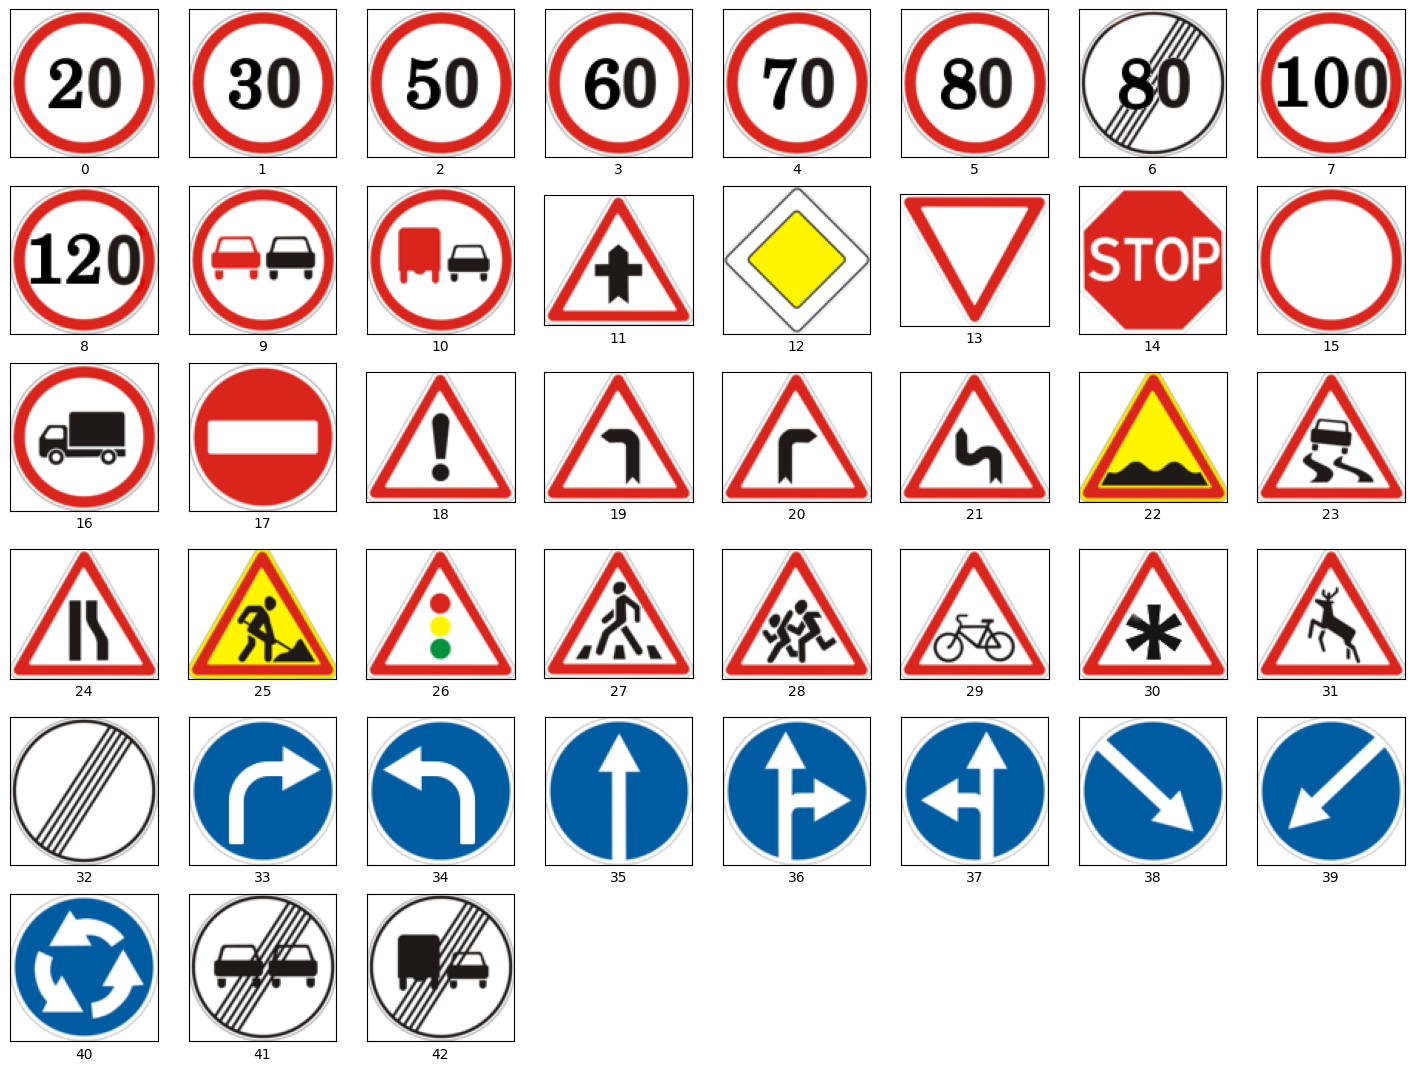

In [4]:
plt.figure(figsize=(18, 18))
for i in range (0,43):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    path = "/content/drive/MyDrive/517_h3_cld/GTSRB/Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

In [5]:
train_image_data = pd.read_csv('/content/drive/MyDrive/517_h3_cld/GTSRB/Train.csv')
train_image_data.describe
train_image_data.value_counts().to_dict()

{(243, 225, 20, 20, 223, 205, 25, 'Train/25/00025_00003_00029.png'): 1,
 (25, 25, 5, 5, 20, 20, 2, 'Train/2/00002_00017_00000.png'): 1,
 (25, 25, 5, 5, 20, 20, 3, 'Train/3/00003_00046_00000.png'): 1,
 (25, 25, 5, 5, 20, 20, 12, 'Train/12/00012_00006_00000.png'): 1,
 (25, 25, 5, 5, 20, 20, 13, 'Train/13/00013_00000_00000.png'): 1,
 (25, 25, 5, 5, 20, 20, 17, 'Train/17/00017_00010_00001.png'): 1,
 (25, 25, 5, 5, 20, 20, 35, 'Train/35/00035_00009_00000.png'): 1,
 (25, 25, 5, 5, 20, 20, 36, 'Train/36/00036_00003_00000.png'): 1,
 (25, 26, 5, 5, 20, 20, 10, 'Train/10/00010_00033_00001.png'): 1,
 (192, 157, 17, 14, 176, 144, 23, 'Train/23/00023_00002_00029.png'): 1,
 (192, 173, 17, 15, 176, 158, 26, 'Train/26/00026_00015_00028.png'): 1,
 (192, 176, 16, 16, 176, 161, 25, 'Train/25/00025_00040_00029.png'): 1,
 (192, 180, 17, 15, 176, 165, 18, 'Train/18/00018_00025_00029.png'): 1,
 (193, 170, 16, 14, 177, 156, 25, 'Train/25/00025_00035_00029.png'): 1,
 (193, 191, 16, 17, 177, 174, 14, 'Train/14/

In [6]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

In [7]:
def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

In [8]:
def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):

        cur_path = os.path.join(path, 'Train', folder)
        print(cur_path)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

In [9]:
def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [10]:
train_images, train_labels = load_train("/content/drive/MyDrive/517_h3_cld/GTSRB/", image_size)

/content/drive/MyDrive/517_h3_cld/GTSRB/Train/9
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/4
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/8
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/42
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/7
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/40
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/39
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/5
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/6
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/41
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/38
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/33
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/37
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/36
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/3
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/32
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/34
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/31
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/35
/content/drive/MyDrive/517_h3_cld/GTSRB/Train/30
/content/drive/MyDrive/517_

In [11]:
print(train_images.shape)
print(train_labels.shape)

(39209, 50, 50, 3)
(39209,)


In [12]:
def preview(images, labels):
    plt.figure(figsize=(16, 16))
    for c in range(len(np.unique(labels))):
        i = random.choice(np.where(labels == c)[0])
        plt.subplot(8, 8, c+1)
        plt.axis('off')
        plt.title('class: {}'.format(c))
        plt.imshow(images[i])

In [13]:
# def augment_imgs(imgs, p):
#     from imgaug import augmenters as iaa
#     augs =  iaa.SomeOf((2, 4),
#           [
#               iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
#               iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
#               iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
#               iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
#               iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
#           ])

#     seq = iaa.Sequential([iaa.Sometimes(p, augs)])
#     res = seq.augment_images(imgs)
#     return res

def count_images_in_classes(lbls):
    dct = {}
    for i in lbls:
        if i in dct:
            dct[i] += 1
        else:
            dct[i] = 1
    return dct

In [14]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 12.3 MB/s eta 0:00:00


In [15]:
import albumentations as A
import numpy as np

def augment_imgs(imgs, p=1):
    augs = A.Compose([
        A.RandomCrop(width=imgs[0].shape[1]-4, height=imgs[0].shape[0]-4, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, p=0.5),
        A.Affine(shear=(-10, 10), p=0.5),
        A.Resize(height=imgs[0].shape[0], width=imgs[0].shape[1], always_apply=True)
    ])

    augmented_imgs = []
    for img in imgs:
        augmented = augs(image=img)
        augmented_imgs.append(augmented["image"])

    return augmented_imgs


In [16]:

def augmentation(imgs, lbls):
    classes = train_image_data.value_counts('ClassId').to_dict()
    for i in range(len(classes)):
        if (classes[i] < MIN_IMGS_IN_CLASS):
            # Number of samples to be added
            add_num = MIN_IMGS_IN_CLASS - classes[i]
            imgs_for_augm = []
            lbls_for_augm = []
            for j in range(add_num):
                im_index = random.choice(np.where(lbls == i)[0])
                imgs_for_augm.append(imgs[im_index])
                lbls_for_augm.append(lbls[im_index])
            augmented_class = augment_imgs(imgs_for_augm, 1)
            augmented_class_np = np.array(augmented_class)
            augmented_lbls_np = np.array(lbls_for_augm)
            imgs = np.concatenate((imgs, augmented_class_np), axis=0)
            lbls = np.concatenate((lbls, augmented_lbls_np), axis=0)
    return (imgs, lbls)

In [17]:
train_images, train_labels = augmentation(train_images, train_labels)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-15-0199c9cf98ec>:9: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=imgs[0].shape[0], width=imgs[0].shape[1], always_apply=True)


In [18]:
print(train_images.shape)
print(train_labels.shape)

(42739, 50, 50, 3)
(42739,)


In [19]:
labels = pd.Series(count_images_in_classes(train_labels))
labels = labels.sort_values(ascending=False)

Loading:  1.3926708698272705


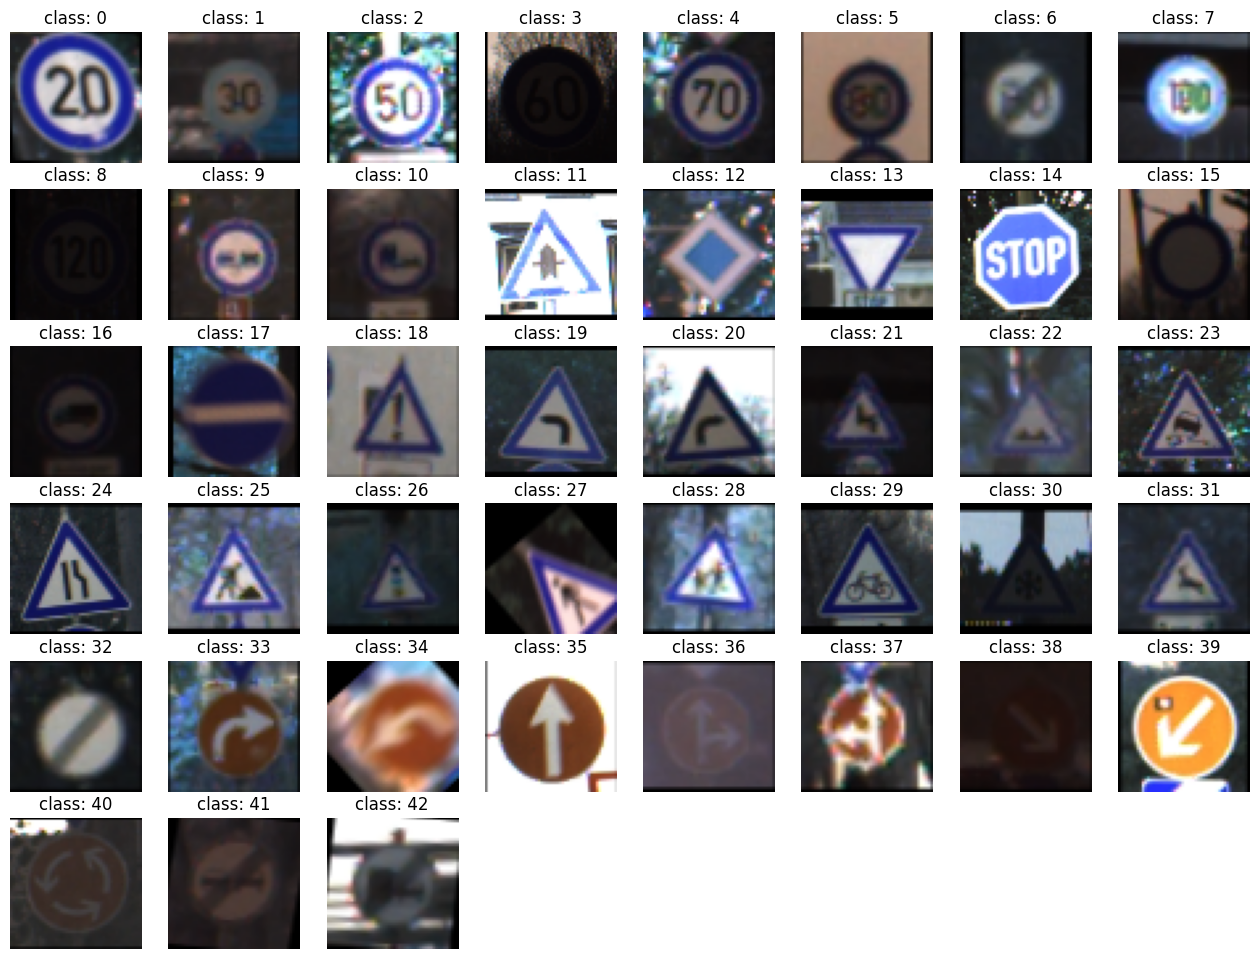

In [20]:
start = time()

from skimage.color import rgb2gray

train_images = train_images.astype('float32') / 255.
# train_images_test = rgb2gray(train_images)

train_labels_cat = utils.to_categorical(train_labels, 43)

preview(train_images, train_labels)
print('Loading: ', time() - start)

In [21]:
classes = 43
batch = 128
epochs = 2
learning_rate = 0.0001

def results(model):
    adam = Adam(learning_rate=learning_rate)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    start = time()
    history = model.fit(train_images, train_labels_cat, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
    train_time = time() - start

    model.summary()

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [22]:
print(train_images.shape)
print(train_labels_cat.shape)

(42739, 50, 50, 3)
(42739, 43)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
268/268 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.6817 - loss: 1.2511 - val_accuracy: 0.8542 - val_loss: 0.6892
Epoch 2/2
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9946 - loss: 0.0221 - val_accuracy: 0.8831 - val_loss: 0.5005


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          44,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,856,323 (174.93 MB)

 Trainable params: 15,285,099 (58.31 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 30,570,200 (116.62 MB)

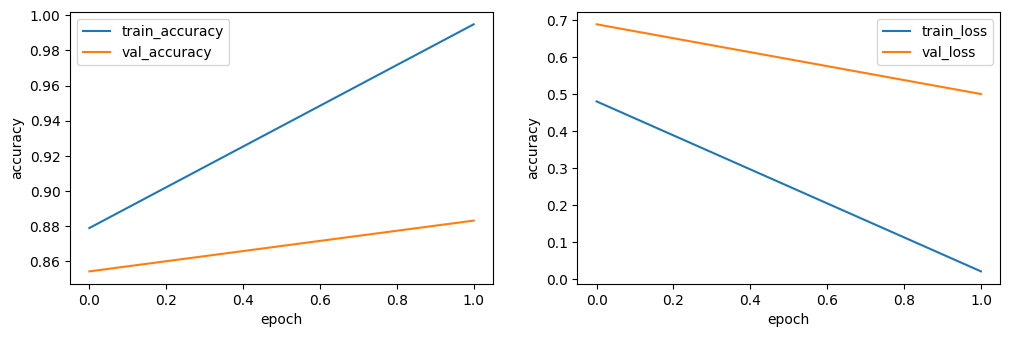

In [23]:
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(43, activation='softmax'))

results(model)

In [24]:
test_image_data = pd.read_csv('/content/drive/MyDrive/517_h3_cld/GTSRB/Test.csv')

In [25]:
test_images, test_labels = load_test("/content/drive/MyDrive/517_h3_cld/GTSRB/", image_size)

Loading:  2852.813362598419


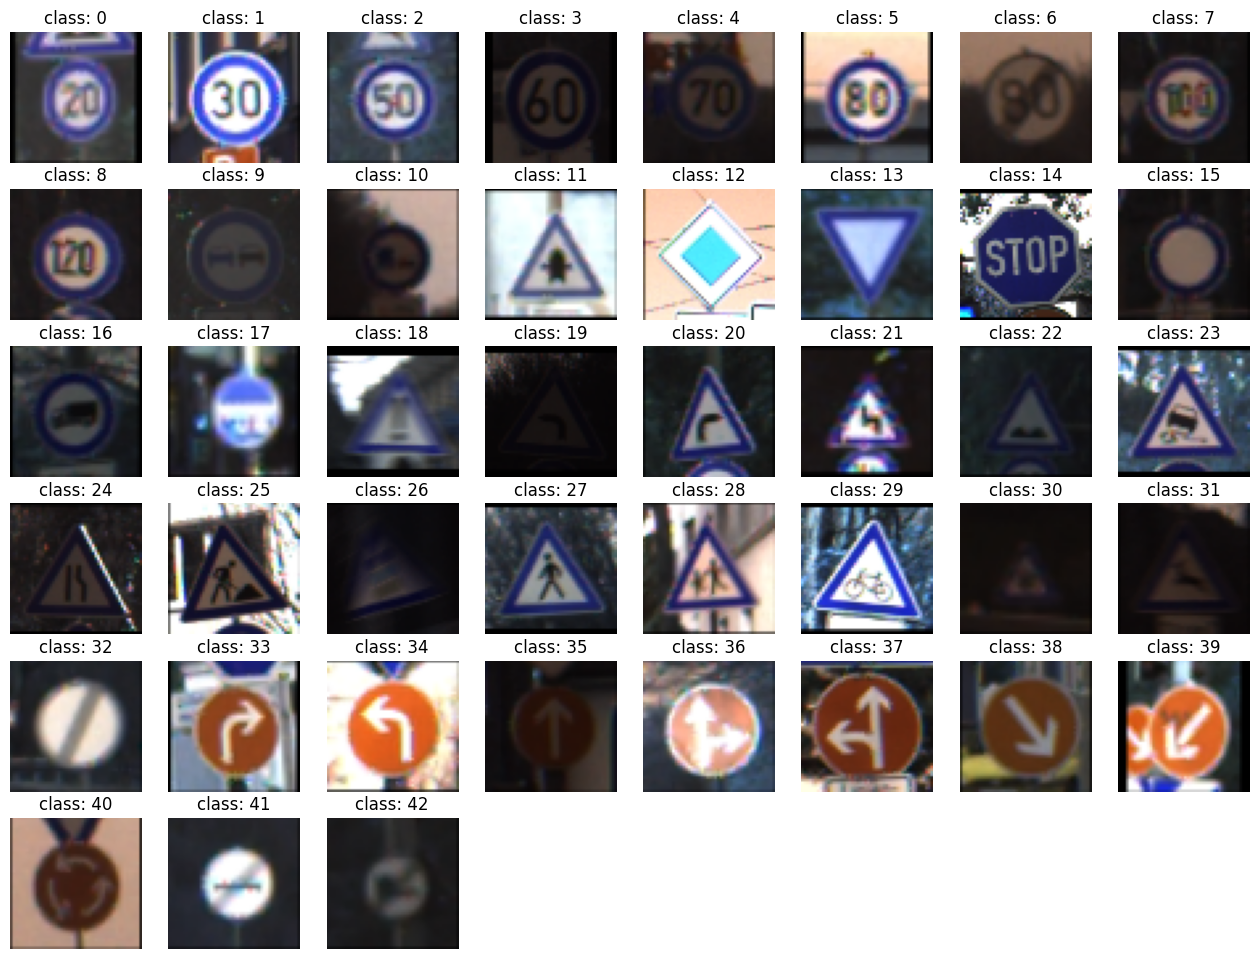

In [26]:
preview(test_images, test_labels)
test_images = test_images.astype('float32') / 255.
test_labels = utils.to_categorical(test_labels, 43)
print('Loading: ', time() - start)

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_time = time() - start

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
print('Test time: ', test_time)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9594 - loss: 0.1439
Test accuracy: 0.95961993932724
Test loss: 0.14325633645057678
Test time:  2860.769627571106


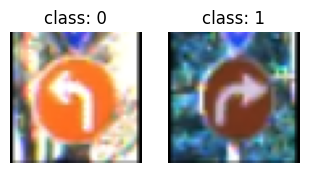

In [28]:
preview(test_images, test_labels)

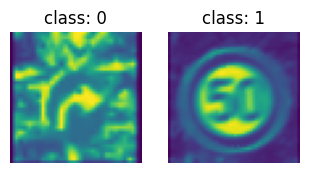

In [29]:
from skimage.color import rgb2gray

test_images = rgb2gray(test_images)
preview(test_images, test_labels)

# TASK 2

In [35]:
print("Loading test data of first 1000 images...")

# Function to load test data (first 1000 images)
def load_test_data():
    # Load CSV file
    test_csv = pd.read_csv('/content/drive/MyDrive/517_h3_cld/GTSRB/Test.csv')
    meta_csv = pd.read_csv('/content/drive/MyDrive/517_h3_cld/GTSRB/Meta.csv')

    print(f"Testing samples: {len(test_csv)}")
    print(f"Meta classes: {len(meta_csv)}")

    # We'll use only the first 1000 images as required
    test_csv = test_csv[:1000]

    X_test = []
    y_test = []
    base_path = '/content/drive/MyDrive/517_h3_cld/GTSRB'

    # Loop through the test CSV
    for idx, row in test_csv.iterrows():
        # Get the path
        img_path = os.path.join(base_path, row['Path'])

        # Read the image
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to 50x50 and convert to RGB (from BGR)
                img = cv2.resize(img, (50, 50))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Append to our list
                X_test.append(img)
                y_test.append(row['ClassId'])

    # Convert to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Convert labels to one-hot encoded vectors
    num_classes = len(meta_csv)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

    # Normalize pixel values to [0, 1]
    X_test = X_test.astype('float32') / 255.0
    y_test = y_test

    print(f"\nFinal data shapes:")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")

    return X_test, y_test, y_test_cat, num_classes

X_test, y_test, y_test_cat, num_classes = load_test_data()

Loading test data of first 1000 images...
Testing samples: 12630
Meta classes: 43

Final data shapes:
X_test: (1000, 50, 50, 3)
y_test: (1000,)


In [36]:
# Function to create adversarial examples using FGSM and PGD
def create_adversarial_examples(model, X_test, y_test_cat, epsilons):
    # Create ART classifier

    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    classifier = TensorFlowV2Classifier(
        model=model,
        nb_classes=num_classes,
        input_shape=X_test.shape[1:],
        loss_object=loss_object,
        clip_values=(0, 1)
    )

    # Dictionary to store results
    accuracy_results = {
        'Clean': [],
        'FGSM': [],
        'PGD': []
    }

    # Clean accuracy
    clean_preds = np.argmax(classifier.predict(X_test.astype(np.float32)), axis=1)
    clean_accuracy = np.sum(clean_preds == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)
    print(f"Clean accuracy: {clean_accuracy:.4f}")

    # Store for all epsilons
    for _ in epsilons:
        accuracy_results['Clean'].append(clean_accuracy)

    # Create adversarial examples using FGSM for each epsilon
    fgsm_examples = {}
    fgsm_accuracies = []

    for eps in epsilons:
        print(f"Creating FGSM adversarial examples with epsilon = {eps}")

        # Create FGSM attack
        fgsm_attack = FastGradientMethod(estimator=classifier, eps=eps)

        # Generate adversarial examples
        fgsm_adv = fgsm_attack.generate(X_test)

        # Store for later visualization
        fgsm_examples[eps] = fgsm_adv

        # Evaluate accuracy on adversarial examples
        fgsm_preds = np.argmax(classifier.predict(fgsm_adv), axis=1)
        fgsm_accuracy = np.sum(fgsm_preds == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)
        fgsm_accuracies.append(fgsm_accuracy)

        print(f"FGSM accuracy with epsilon = {eps}: {fgsm_accuracy:.4f}")

    accuracy_results['FGSM'] = fgsm_accuracies

    # Create adversarial examples using PGD for each epsilon
    pgd_examples = {}
    pgd_accuracies = []

    for eps in epsilons:
        print(f"Creating PGD adversarial examples with epsilon = {eps}")

        # Create PGD attack
        pgd_attack = ProjectedGradientDescent(
            estimator=classifier,
            eps=eps,
            eps_step=eps/10,  # Step size is a fraction of epsilon
            max_iter=40    # Number of iterations
            #random_init=True  # Use random initialization
        )

        # Generate adversarial examples
        pgd_adv = pgd_attack.generate(X_test)

        # Store for later visualization
        pgd_examples[eps] = pgd_adv

        # Evaluate accuracy on adversarial examples
        pgd_preds = np.argmax(classifier.predict(pgd_adv), axis=1)
        pgd_accuracy = np.sum(pgd_preds == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)
        pgd_accuracies.append(pgd_accuracy)

        print(f"PGD accuracy with epsilon = {eps}: {pgd_accuracy:.4f}")

    accuracy_results['PGD'] = pgd_accuracies

    return accuracy_results, fgsm_examples, pgd_examples


In [37]:
# Define epsilon values
epsilons = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

# Create VGG16 adversarial examples
print("\nCreating adversarial examples for VGG16...")
vgg_results, vgg_fgsm_examples, vgg_pgd_examples = create_adversarial_examples(model, X_test, y_test_cat, epsilons)


Creating adversarial examples for VGG16...
Clean accuracy: 0.8610
Creating FGSM adversarial examples with epsilon = 0.00392156862745098
FGSM accuracy with epsilon = 0.00392156862745098: 0.6810
Creating FGSM adversarial examples with epsilon = 0.00784313725490196
FGSM accuracy with epsilon = 0.00784313725490196: 0.4940
Creating FGSM adversarial examples with epsilon = 0.011764705882352941
FGSM accuracy with epsilon = 0.011764705882352941: 0.3830
Creating FGSM adversarial examples with epsilon = 0.01568627450980392
FGSM accuracy with epsilon = 0.01568627450980392: 0.3100
Creating FGSM adversarial examples with epsilon = 0.0196078431372549
FGSM accuracy with epsilon = 0.0196078431372549: 0.2660
Creating FGSM adversarial examples with epsilon = 0.03137254901960784
FGSM accuracy with epsilon = 0.03137254901960784: 0.1860
Creating FGSM adversarial examples with epsilon = 0.0392156862745098
FGSM accuracy with epsilon = 0.0392156862745098: 0.1550
Creating FGSM adversarial examples with epsilo

PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.00392156862745098: 0.6160
Creating PGD adversarial examples with epsilon = 0.00784313725490196


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.00784313725490196: 0.4130
Creating PGD adversarial examples with epsilon = 0.011764705882352941


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.011764705882352941: 0.2720
Creating PGD adversarial examples with epsilon = 0.01568627450980392


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.01568627450980392: 0.2100
Creating PGD adversarial examples with epsilon = 0.0196078431372549


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.0196078431372549: 0.1640
Creating PGD adversarial examples with epsilon = 0.03137254901960784


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.03137254901960784: 0.0940
Creating PGD adversarial examples with epsilon = 0.0392156862745098


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.0392156862745098: 0.0850
Creating PGD adversarial examples with epsilon = 0.0784313725490196


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.0784313725490196: 0.0780
Creating PGD adversarial examples with epsilon = 0.19607843137254902


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.19607843137254902: 0.0670
Creating PGD adversarial examples with epsilon = 0.3137254901960784


PGD - Batches: 0it [00:00, ?it/s]

PGD accuracy with epsilon = 0.3137254901960784: 0.0630


In [42]:
# Function to plot accuracy vs. perturbation
def plot_accuracy_vs_perturbation(model_name, epsilons, accuracy_results):
    plt.figure(figsize=(10, 6))

    plt.plot(epsilons, accuracy_results['Clean'], 'k--', label='Clean')
    plt.plot(epsilons, accuracy_results['FGSM'], 'b-o', label='FGSM')
    plt.plot(epsilons, accuracy_results['PGD'], 'r-o', label='PGD')

    plt.title(f'{model_name} - Accuracy vs. Perturbation')
    plt.xlabel('Epsilon (Perturbation Magnitude)')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.grid(True, alpha=0.05)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_accuracy_vs_perturbation.png')
    plt.show()

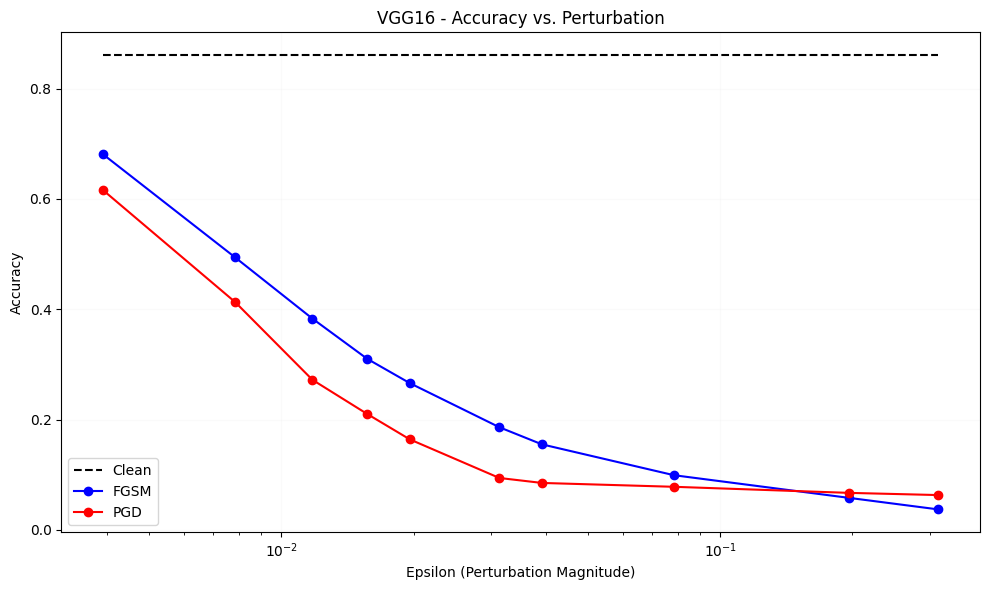

In [43]:
# Plot VGG16 accuracy vs. perturbation
plot_accuracy_vs_perturbation('VGG16', epsilons, vgg_results)


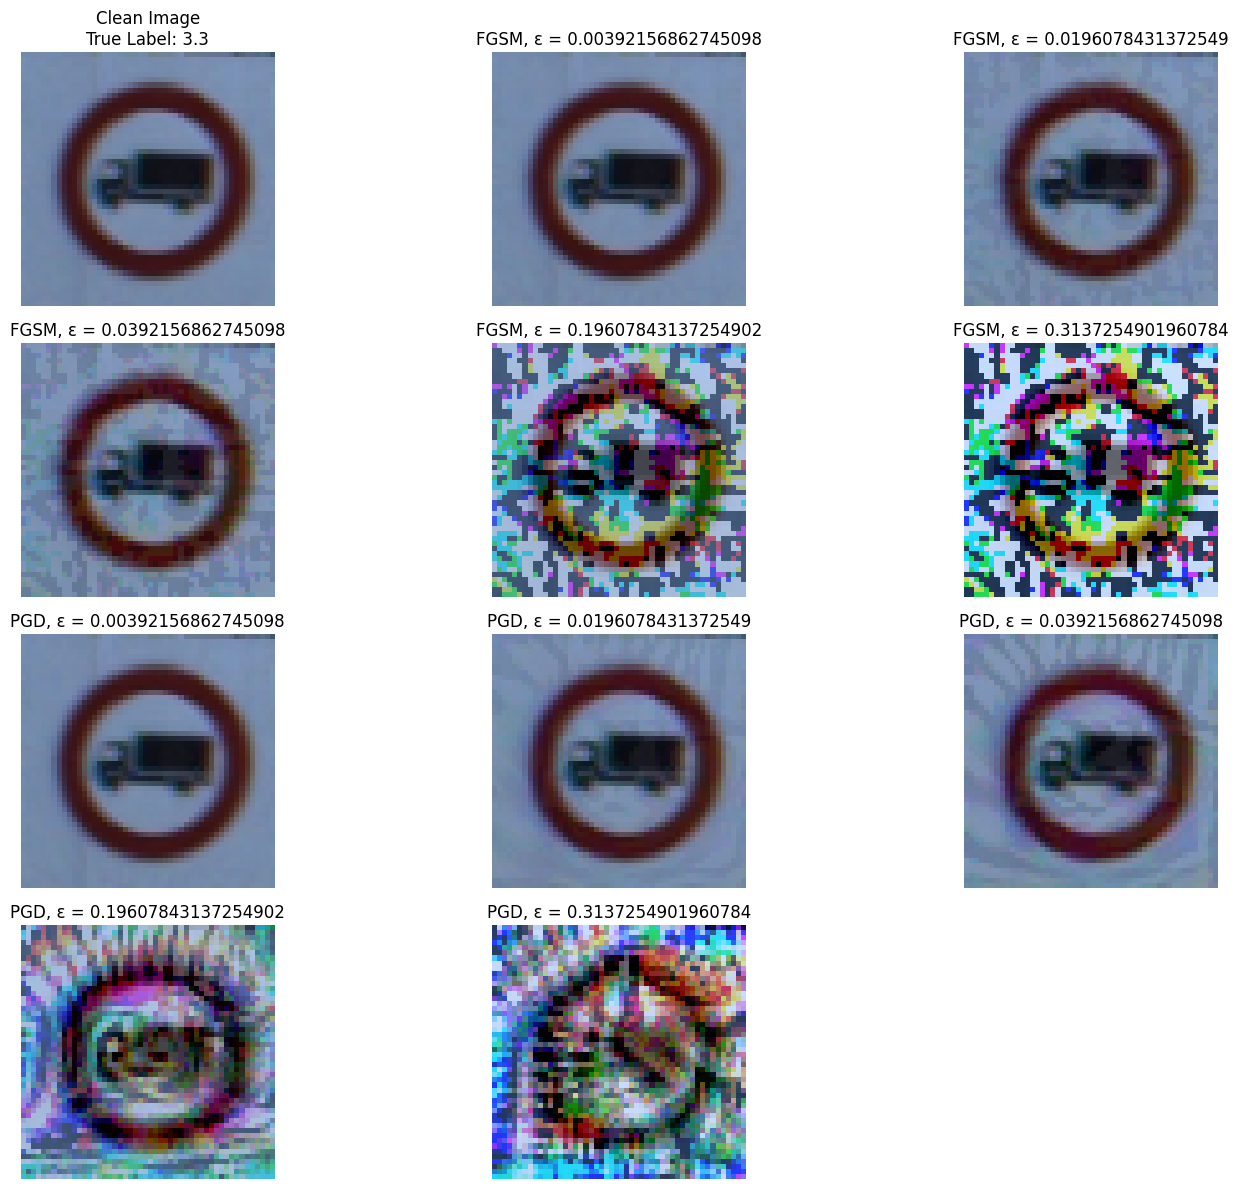

In [60]:
def visualize_adversarial_examples(X_test, y_test, fgsm_examples, pgd_examples, selected_epsilons, meta_csv='/content/drive/MyDrive/517_h3_cld/GTSRB/Meta.csv'):
    import matplotlib.pyplot as plt
    import pandas as pd

    meta_csv = pd.read_csv(meta_csv)

    # Image index to visualize
    img_idx = 0
    class_id = y_test[img_idx]
    class_name = meta_csv[meta_csv['ClassId'] == class_id]['SignId'].values[0]


    num_eps = len(selected_epsilons)
    total_plots = 1 + num_eps * 2  # 1 clean + n FGSM + n PGD

    rows = (total_plots + 2) // 3  # calculate rows needed for 3 columns
    plt.figure(figsize=(15, rows * 3))

    # Plot clean image
    plt.subplot(rows, 3, 1)
    plt.imshow(X_test[img_idx])
    plt.title(f"Clean Image\nTrue Label: {class_name}")
    plt.axis('off')

    # FGSM adversarial images
    for i, eps in enumerate(selected_epsilons):
        plt.subplot(rows, 3, i + 2)
        plt.imshow(fgsm_examples[eps][img_idx].clip(0, 1))
        plt.title(f"FGSM, ε = {eps}")
        plt.axis('off')

    # PGD adversarial images
    for i, eps in enumerate(selected_epsilons):
        plt.subplot(rows, 3, i + 2 + len(selected_epsilons))
        plt.imshow(pgd_examples[eps][img_idx].clip(0, 1))
        plt.title(f"PGD, ε = {eps}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('adversarial_examples.png')
    plt.show()


# Visualize VGG16 adversarial examples
selected_epsilons = [1/255, 5/255, 10/255, 50/255, 80/255]
visualize_adversarial_examples(X_test, y_test, vgg_fgsm_examples, vgg_pgd_examples, selected_epsilons, meta_csv='/content/drive/MyDrive/517_h3_cld/GTSRB/Meta.csv')


In [52]:
# Function to create the accuracy table
def create_accuracy_table(model_name, epsilons, accuracy_results):
    # Select specific epsilon values for the table
    selected_indices = [0, 4, 6, 9]  # 1/255, 5/255, 10/255, 80/255

    table_data = {
        'Model': [f"{model_name} - Clean", f"{model_name} - FGSM", f"{model_name} - PGD"],
        'Clean images': [accuracy_results['Clean'][0]] * 3,
        f'ε={epsilons[0]}': [accuracy_results['Clean'][0], accuracy_results['FGSM'][0], accuracy_results['PGD'][0]],
        f'ε={epsilons[4]}': [accuracy_results['Clean'][4], accuracy_results['FGSM'][4], accuracy_results['PGD'][4]],
        f'ε={epsilons[6]}': [accuracy_results['Clean'][6], accuracy_results['FGSM'][6], accuracy_results['PGD'][6]],
        f'ε={epsilons[9]}': [accuracy_results['Clean'][9], accuracy_results['FGSM'][9], accuracy_results['PGD'][9]]
    }

    table_df = pd.DataFrame(table_data)
    print(f"\nClassification accuracy for {model_name}:")
    print(table_df)

    return table_df

# Create VGG16 accuracy table
vgg_table = create_accuracy_table('VGG16', epsilons, vgg_results)



Classification accuracy for VGG16:
           Model  Clean images  ε=0.00392156862745098  ε=0.0196078431372549  \
0  VGG16 - Clean         0.861                  0.861                 0.861   
1   VGG16 - FGSM         0.861                  0.681                 0.266   
2    VGG16 - PGD         0.861                  0.616                 0.164   

   ε=0.0392156862745098  ε=0.3137254901960784  
0                 0.861                 0.861  
1                 0.155                 0.037  
2                 0.085                 0.063  


# Task 3

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
import cv2
import os

# Function to load stop sign images (class 14) from test data
def load_sign_images():
    # Load CSV file
    test_csv = pd.read_csv('/content/drive/MyDrive/517_h3_cld/GTSRB/Test.csv')
    meta_csv = pd.read_csv('/content/drive/MyDrive/517_h3_cld/GTSRB/Meta.csv')

    print(f"Testing samples: {len(test_csv)}")
    print(f"Meta classes: {len(meta_csv)}")

    # Filter for Stop sign images (ClassId = 14)
    stop_sign_data = test_csv[test_csv['ClassId'] == 14]
    print(f"Number of Stop sign images: {len(stop_sign_data)}")

    # Also load some Speed Limit 30 sign images (ClassId = 1) for comparison
    speed_limit_data = test_csv[test_csv['ClassId'] == 1]
    print(f"Number of Speed Limit 30 sign images: {len(speed_limit_data)}")

    X_stop = []
    y_stop = []

    base_path = '/content/drive/MyDrive/517_h3_cld/GTSRB'

    # Loop through the Stop sign images
    for idx, row in stop_sign_data.iterrows():
        # Get the path
        img_path = os.path.join(base_path, row['Path'])

        # Read the image
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to 32x32 and convert to RGB (from BGR)
                img = cv2.resize(img, (50,50))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Append to our list
                X_stop.append(img)
                y_stop.append(row['ClassId'])

    X_speed = []
    y_speed = []

    # Loop through the Speed Limit 30 images (for comparison)
    for idx, row in speed_limit_data[:len(stop_sign_data)].iterrows():  # Take same number as stop signs
        # Get the path
        img_path = os.path.join(base_path, row['Path'])

        # Read the image
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to 32x32 and convert to RGB (from BGR)
                img = cv2.resize(img, (50,50))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Append to our list
                X_speed.append(img)
                y_speed.append(row['ClassId'])

    # Convert to numpy arrays
    X_stop = np.array(X_stop)
    y_stop = np.array(y_stop)
    X_speed = np.array(X_speed)
    y_speed = np.array(y_speed)

    # Create one-hot encoded labels
    num_classes = len(meta_csv)
    y_stop_cat = tf.keras.utils.to_categorical(y_stop, num_classes)
    y_speed_cat = tf.keras.utils.to_categorical(y_speed, num_classes)

    # Normalize pixel values to [0, 1]
    X_stop = X_stop.astype('float32') / 255.0
    X_speed = X_speed.astype('float32') / 255.0

    print(f"\nFinal data shapes:")
    print(f"X_stop: {X_stop.shape}")
    print(f"y_stop: {y_stop.shape}")
    print(f"X_speed: {X_speed.shape}")
    print(f"y_speed: {y_speed.shape}")

    return X_stop, y_stop, y_stop_cat, X_speed, y_speed, y_speed_cat, num_classes

# Load stop & speed sign images
print("Loading Stop & Speed sign images...")
X_stop, y_stop, y_stop_cat, X_speed, y_speed, y_speed_cat, num_classes = load_sign_images()

Loading Stop & Speed sign images...
Testing samples: 12630
Meta classes: 43
Number of Stop sign images: 270
Number of Speed Limit 30 sign images: 720

Final data shapes:
X_stop: (270, 50, 50, 3)
y_stop: (270,)
X_speed: (270, 50, 50, 3)
y_speed: (270,)


In [68]:
# Function to create targeted adversarial examples
def create_targeted_adversarial_examples(model, X_stop, y_stop_cat, epsilons, target_class=1):
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    classifier = TensorFlowV2Classifier(
        model=model,
        nb_classes=num_classes,
        input_shape=X_test.shape[1:],
        loss_object=loss_object,
        clip_values=(0, 1)
    )

    # Create ART classifier
    # classifier = KerasClassifier(model=model, clip_values=(0, 1))

    # Dictionary to store results
    results = {
        'original_accuracy': [],  # Accuracy on original class (Stop sign)
        'target_accuracy': []     # Success rate of misclassification as target class (Speed limit 30)
    }

    # Create targeted one-hot encoded label for the target class (Speed limit 30)
    num_samples = len(X_stop)
    target_labels = np.zeros_like(y_stop_cat)
    target_labels[:, target_class] = 1  # Set target class to 1 (Speed limit 30)

    # Evaluate clean accuracy
    clean_preds = np.argmax(classifier.predict(X_stop), axis=1)
    original_class_accuracy = np.mean(clean_preds == np.argmax(y_stop_cat, axis=1))
    target_class_success = np.mean(clean_preds == target_class)

    print(f"Clean accuracy on original class (Stop sign): {original_class_accuracy:.4f}")
    print(f"Clean misclassification rate as target class (Speed limit 30): {target_class_success:.4f}")

    # Dictionary to store adversarial examples
    pgd_examples = {}

    # Create targeted PGD adversarial examples for each epsilon
    for eps in epsilons:
        print(f"Creating targeted PGD adversarial examples with epsilon = {eps}")

        # Create PGD attack
        pgd_attack = ProjectedGradientDescent(
            estimator=classifier,
            eps=eps,
            eps_step=eps/10,  # Step size is a fraction of epsilon
            max_iter=100,     # More iterations for targeted attack
            targeted=True,    # This is a targeted attack
            batch_size=32
        )

        # Generate adversarial examples
        pgd_adv = pgd_attack.generate(X_stop, target_labels)

        # Store for later visualization
        pgd_examples[eps] = pgd_adv

        # Evaluate predictions on adversarial examples
        adv_preds = np.argmax(classifier.predict(pgd_adv), axis=1)

        # Calculate metrics
        original_accuracy = np.mean(adv_preds == np.argmax(y_stop_cat, axis=1))
        target_success = np.mean(adv_preds == target_class)

        results['original_accuracy'].append(original_accuracy)
        results['target_accuracy'].append(target_success)

        print(f"PGD (ε={eps}): Stop sign accuracy: {original_accuracy:.4f}, "
              f"Speed limit 30 success rate: {target_success:.4f}")

    # Dictionary to store FGSM adversarial examples
    fgsm_examples = {}
    fgsm_results = {
        'original_accuracy': [],  # Accuracy on original class (Stop sign)
        'target_accuracy': []     # Success rate of misclassification as target class (Speed limit 30)
    }

    # Create targeted FGSM adversarial examples for each epsilon
    for eps in epsilons:
        print(f"Creating targeted FGSM adversarial examples with epsilon = {eps}")

        # Create FGSM attack
        fgsm_attack = FastGradientMethod(
            estimator=classifier,
            eps=eps,
            targeted=True,    # This is a targeted attack
            batch_size=32
        )

        # Generate adversarial examples
        fgsm_adv = fgsm_attack.generate(X_stop, target_labels)

        # Store for later visualization
        fgsm_examples[eps] = fgsm_adv

        # Evaluate predictions on adversarial examples
        adv_preds = np.argmax(classifier.predict(fgsm_adv), axis=1)

        # Calculate metrics
        original_accuracy = np.mean(adv_preds == np.argmax(y_stop_cat, axis=1))
        target_success = np.mean(adv_preds == target_class)

        fgsm_results['original_accuracy'].append(original_accuracy)
        fgsm_results['target_accuracy'].append(target_success)

        print(f"FGSM (ε={eps}): Stop sign accuracy: {original_accuracy:.4f}, "
              f"Speed limit 30 success rate: {target_success:.4f}")

    return results, pgd_examples, fgsm_results, fgsm_examples

print("\nCreating targeted adversarial examples...")
pgd_results, pgd_examples, fgsm_results, fgsm_examples = create_targeted_adversarial_examples(model, X_stop, y_stop_cat, epsilons, target_class=1)



Creating targeted adversarial examples...
Clean accuracy on original class (Stop sign): 0.8963
Clean misclassification rate as target class (Speed limit 30): 0.0000
Creating targeted PGD adversarial examples with epsilon = 0.00392156862745098


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.00392156862745098): Stop sign accuracy: 0.6556, Speed limit 30 success rate: 0.2037
Creating targeted PGD adversarial examples with epsilon = 0.00784313725490196


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.00784313725490196): Stop sign accuracy: 0.3296, Speed limit 30 success rate: 0.5741
Creating targeted PGD adversarial examples with epsilon = 0.011764705882352941


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.011764705882352941): Stop sign accuracy: 0.1185, Speed limit 30 success rate: 0.8333
Creating targeted PGD adversarial examples with epsilon = 0.01568627450980392


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.01568627450980392): Stop sign accuracy: 0.0037, Speed limit 30 success rate: 0.9889
Creating targeted PGD adversarial examples with epsilon = 0.0196078431372549


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.0196078431372549): Stop sign accuracy: 0.0000, Speed limit 30 success rate: 1.0000
Creating targeted PGD adversarial examples with epsilon = 0.03137254901960784


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.03137254901960784): Stop sign accuracy: 0.0000, Speed limit 30 success rate: 1.0000
Creating targeted PGD adversarial examples with epsilon = 0.0392156862745098


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.0392156862745098): Stop sign accuracy: 0.0000, Speed limit 30 success rate: 1.0000
Creating targeted PGD adversarial examples with epsilon = 0.0784313725490196


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.0784313725490196): Stop sign accuracy: 0.0000, Speed limit 30 success rate: 1.0000
Creating targeted PGD adversarial examples with epsilon = 0.19607843137254902


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.19607843137254902): Stop sign accuracy: 0.0000, Speed limit 30 success rate: 1.0000
Creating targeted PGD adversarial examples with epsilon = 0.3137254901960784


PGD - Batches: 0it [00:00, ?it/s]

PGD (ε=0.3137254901960784): Stop sign accuracy: 0.0000, Speed limit 30 success rate: 1.0000
Creating targeted FGSM adversarial examples with epsilon = 0.00392156862745098
FGSM (ε=0.00392156862745098): Stop sign accuracy: 0.6444, Speed limit 30 success rate: 0.1074
Creating targeted FGSM adversarial examples with epsilon = 0.00784313725490196
FGSM (ε=0.00784313725490196): Stop sign accuracy: 0.3444, Speed limit 30 success rate: 0.4037
Creating targeted FGSM adversarial examples with epsilon = 0.011764705882352941
FGSM (ε=0.011764705882352941): Stop sign accuracy: 0.0741, Speed limit 30 success rate: 0.5889
Creating targeted FGSM adversarial examples with epsilon = 0.01568627450980392
FGSM (ε=0.01568627450980392): Stop sign accuracy: 0.0370, Speed limit 30 success rate: 0.6148
Creating targeted FGSM adversarial examples with epsilon = 0.0196078431372549
FGSM (ε=0.0196078431372549): Stop sign accuracy: 0.0222, Speed limit 30 success rate: 0.6222
Creating targeted FGSM adversarial examples

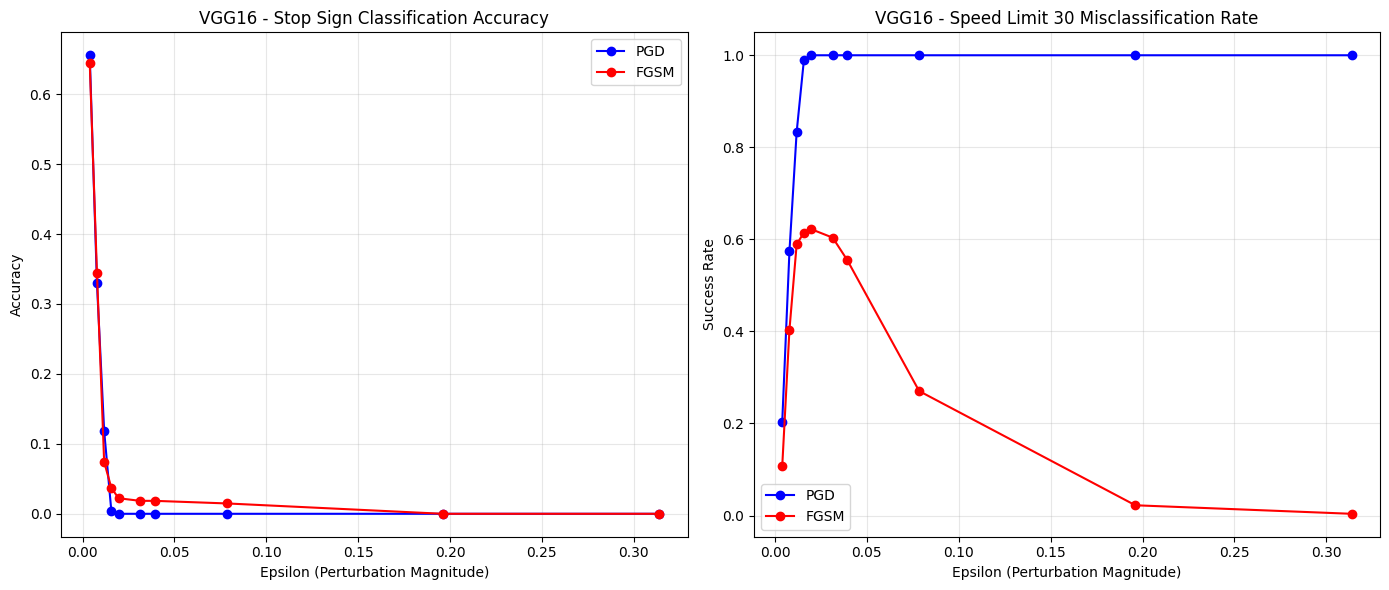

In [69]:

# Function to visualize the results
def plot_targeted_attack_results(model_name, epsilons, pgd_results, fgsm_results):
    plt.figure(figsize=(14, 6))

    # Plot original class accuracy (how many stop signs are still classified correctly)
    plt.subplot(1, 2, 1)
    plt.plot(epsilons, pgd_results['original_accuracy'], 'b-o', label='PGD')
    plt.plot(epsilons, fgsm_results['original_accuracy'], 'r-o', label='FGSM')
    plt.title(f'{model_name} - Stop Sign Classification Accuracy')
    plt.xlabel('Epsilon (Perturbation Magnitude)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot target class success rate (how many stop signs are misclassified as speed limit 30)
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, pgd_results['target_accuracy'], 'b-o', label='PGD')
    plt.plot(epsilons, fgsm_results['target_accuracy'], 'r-o', label='FGSM')
    plt.title(f'{model_name} - Speed Limit 30 Misclassification Rate')
    plt.xlabel('Epsilon (Perturbation Magnitude)')
    plt.ylabel('Success Rate')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_targeted_attack_results.png')
    plt.show()

# Plot results
plot_targeted_attack_results('VGG16', epsilons, pgd_results, fgsm_results)

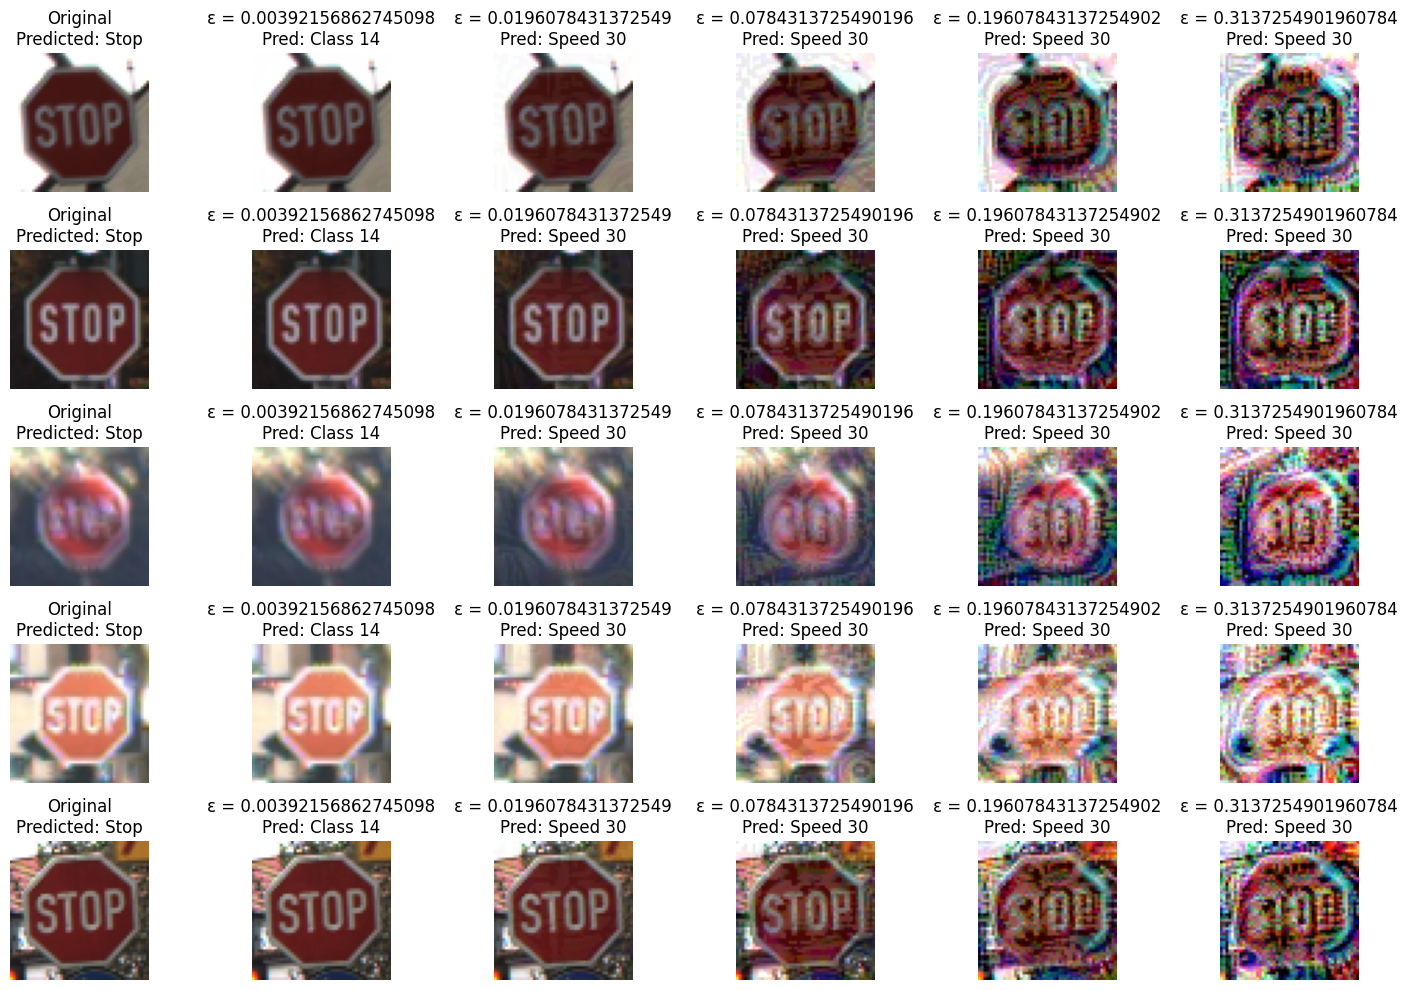

In [71]:
# Function to visualize adversarial examples
def visualize_targeted_adversarial_examples(model, X_stop, pgd_examples, selected_epsilons):
    # # Create ART classifier for predictions
    # classifier = KerasClassifier(model=model, clip_values=(0, 1))
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    classifier = TensorFlowV2Classifier(
        model=model,
        nb_classes=num_classes,
        input_shape=X_test.shape[1:],
        loss_object=loss_object,
        clip_values=(0, 1)
    )

    plt.figure(figsize=(15, 10))

    # Select 5 different images for visualization
    img_indices = [0, 1, 2, 3, 4]

    for i, idx in enumerate(img_indices):
        # Get original image
        original_img = X_stop[idx]

        # Get original prediction
        original_pred = np.argmax(classifier.predict(original_img[np.newaxis, ...]), axis=1)[0]

        # Plot original image
        plt.subplot(len(img_indices), len(selected_epsilons) + 1, i * (len(selected_epsilons) + 1) + 1)
        plt.imshow(original_img)
        plt.title(f"Original\nPredicted: Stop")
        plt.axis('off')

        # Plot adversarial examples for different epsilon values
        for j, eps in enumerate(selected_epsilons):
            # Get adversarial image
            adv_img = pgd_examples[eps][idx]

            # Get adversarial prediction
            adv_pred = np.argmax(classifier.predict(adv_img[np.newaxis, ...]), axis=1)[0]

            # Determine prediction label
            pred_label = "Speed 30" if adv_pred == 1 else f"Class {adv_pred}"

            # Plot adversarial image
            plt.subplot(len(img_indices), len(selected_epsilons) + 1, i * (len(selected_epsilons) + 1) + j + 2)
            plt.imshow(adv_img.clip(0, 1))  # Clip to valid pixel values
            plt.title(f"ε = {eps}\nPred: {pred_label}")
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('targeted_adversarial_examples.png')
    plt.show()

# Visualize adversarial examples
selected_epsilons = [1/255, 5/255, 20/255, 50/255, 80/255]
visualize_targeted_adversarial_examples(model, X_stop, pgd_examples, selected_epsilons)

In [74]:
# Function to create a table of results
def create_targeted_attack_table(epsilons, pgd_results):
    # Create a DataFrame for the table
    table_data = {
        'Perturbation Level': [f'ε={eps}' for eps in epsilons],
        'PGD attack - Stop sign images': pgd_results['original_accuracy'],
        'PGD attack - Speed Limit 30 sign images': pgd_results['target_accuracy']
    }

    table_df = pd.DataFrame(table_data)
    print("\nClassification accuracy of the model on adversarial original and target class images:")
    print(table_df)

    # Save to CSV
    table_df.to_csv('vgg_targeted_attack_results.csv', index=False)

    return table_df

# Create table of results
table_df = create_targeted_attack_table(epsilons, pgd_results)


Classification accuracy of the model on adversarial original and target class images:
       Perturbation Level  PGD attack - Stop sign images  \
0   ε=0.00392156862745098                       0.655556   
1   ε=0.00784313725490196                       0.329630   
2  ε=0.011764705882352941                       0.118519   
3   ε=0.01568627450980392                       0.003704   
4    ε=0.0196078431372549                       0.000000   
5   ε=0.03137254901960784                       0.000000   
6    ε=0.0392156862745098                       0.000000   
7    ε=0.0784313725490196                       0.000000   
8   ε=0.19607843137254902                       0.000000   
9    ε=0.3137254901960784                       0.000000   

   PGD attack - Speed Limit 30 sign images  
0                                 0.203704  
1                                 0.574074  
2                                 0.833333  
3                                 0.988889  
4                          

In [75]:
# Determine best perturbation size
best_pgd_eps_idx = np.argmax(pgd_results['target_accuracy'])
best_pgd_eps = epsilons[best_pgd_eps_idx]
best_pgd_success = pgd_results['target_accuracy'][best_pgd_eps_idx]
print(f"\nBest perturbation size for PGD: ε = {best_pgd_eps} with {best_pgd_success:.4f} success rate")


Best perturbation size for PGD: ε = 0.0196078431372549 with 1.0000 success rate
